Get dataframe

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('../song_features.csv')
df.head()

,id,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,0JXXNGljqupsJaZsgSbMZV,0.0267,0.684,0.607,0.000307,11,0.1910,-8.127,0,0.1000,81.001,4,0.4980
1,51pshtuYkgUQnt5huMPbKL,0.0135,0.794,0.766,0.000000,9,0.0785,-3.894,0,0.0377,127.007,4,0.5500
2,7BqBn9nzAq8spo5e7cZ0dJ,0.0134,0.635,0.841,0.000000,5,0.0622,-5.379,1,0.0422,109.021,4,0.4240
3,161DnLWsx1i3u1JT05lzqU,0.5110,0.498,0.590,0.000000,1,0.1070,-4.721,0,0.0320,145.867,4,0.0784
4,1eUGmzzvahJjOSWgDHuRlv,0.8560,0.372,0.239,0.000175,6,0.1680,-11.314,0,0.0296,113.451,4,0.1270


Box plot for 9 features

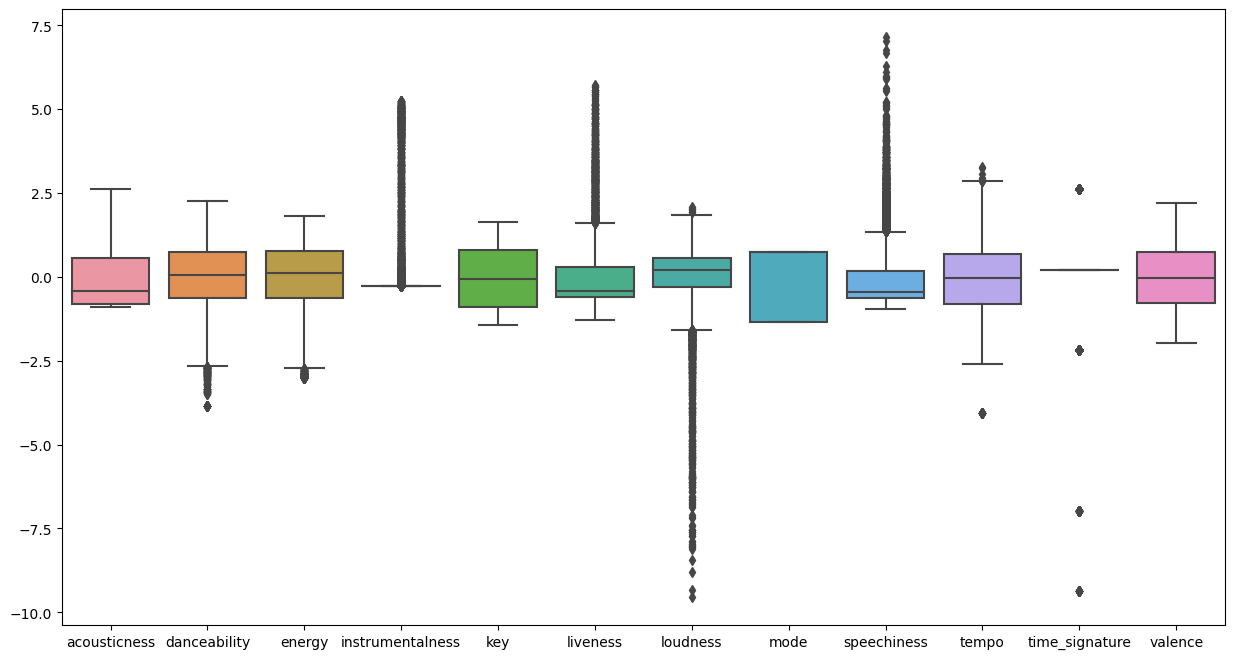

In [40]:
from sklearn.preprocessing import StandardScaler
features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']
x = df.loc[:, features].values
x = StandardScaler().fit_transform(x)
x = pd.DataFrame(x, columns=features)
sns.boxplot(data=x)
# Resize plot
plt.gcf().set_size_inches(15, 8)
plt.show()

Apply PCA

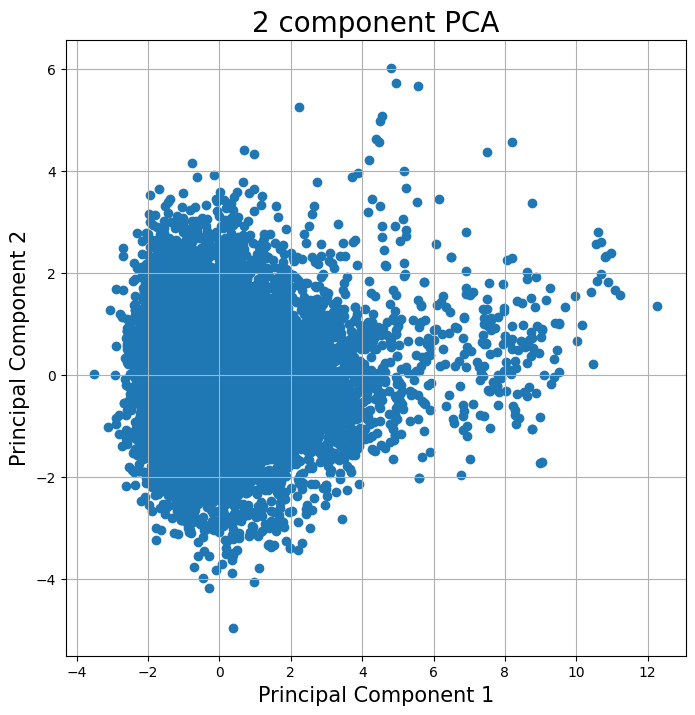

In [41]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
pca.explained_variance_ratio_

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
ax.scatter(principalDf['principal component 1'], principalDf['principal component 2'])
ax.grid()